In [1]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
import os
import sys

import clip

import importlib

import contextlib

import json
import os
import random


sys.path.insert(0, os.path.abspath('../..'))
sys.path.insert(0, os.path.abspath('../../..'))
import numpy as np
import torch
from collections import defaultdict
from utils import get_default_path
from utils import Stopwatch
import time

import datetime


import ai.stabledisco as sd
import ai.torchmodules as torchmodules
import ai.torchmodules.data as torchdata
import ai.torchmodules.utils as torchutils
import ai.stabledisco.utils as sdutils
import ai.stabledisco.data as sddata

import torch
import torch.nn as nn
import pandas as pd

from clip.clip import _tokenizer as clip_tokenizer
import ai.stabledisco.decoderpipeline as decoderpipeline

In [2]:
import re 

def parse_loss(training_log_lines):
    losses = []
    learning_rates = []

    for line in training_log_lines:
        matches = re.findall(fr"(?<=loss )\d+\.\d+", line)
        for match in matches:
            losses.append(float(match))
            
        matches = re.finditer(fr"(?<=Learning rate: \[)\d+\.\d+(e-?\d+)?(?=])", line)
        for match in matches:
            learning_rates.append(float(match.group(0)))
        
    return losses, learning_rates

In [48]:
training_log_lines = """
Starting training
Starting epoch 0
  200/34200 batches | batch/sec  5.83 | rem mins    97 | loss 0.1090 | ppl   1.1152
Learning rate: [1.575375000000001e-06]
  400/34200 batches | batch/sec  6.13 | rem mins    92 | loss 0.1081 | ppl   1.1142
Learning rate: [1.6503749999999992e-06]
  600/34200 batches | batch/sec  6.14 | rem mins    91 | loss 0.1088 | ppl   1.1149
Learning rate: [1.725375000000001e-06]
  800/34200 batches | batch/sec  5.98 | rem mins    93 | loss 0.1079 | ppl   1.1140
Learning rate: [1.8003749999999995e-06]
 1000/34200 batches | batch/sec  6.49 | rem mins    85 | loss 0.1084 | ppl   1.1145
Learning rate: [1.875375000000001e-06]
 1200/34200 batches | batch/sec  5.93 | rem mins    93 | loss 0.1086 | ppl   1.1147
Learning rate: [1.9503749999999995e-06]
 1400/34200 batches | batch/sec  6.08 | rem mins    90 | loss 0.1061 | ppl   1.1120
Learning rate: [2.0253750000000013e-06]
 1600/34200 batches | batch/sec  6.12 | rem mins    89 | loss 0.1072 | ppl   1.1131
Learning rate: [2.1003749999999998e-06]
 1800/34200 batches | batch/sec  5.96 | rem mins    91 | loss 0.1098 | ppl   1.1161
Learning rate: [2.1753750000000016e-06]
 2000/34200 batches | batch/sec  5.95 | rem mins    90 | loss 0.1087 | ppl   1.1149
Learning rate: [2.2503749999999996e-06]
 2200/34200 batches | batch/sec  5.98 | rem mins    89 | loss 0.1069 | ppl   1.1129
Learning rate: [2.3253750000000014e-06]
 2400/34200 batches | batch/sec  6.61 | rem mins    80 | loss 0.1072 | ppl   1.1132
Learning rate: [2.400375e-06]
 2600/34200 batches | batch/sec  6.48 | rem mins    81 | loss 0.1062 | ppl   1.1120
Learning rate: [2.4753749999999983e-06]
 2800/34200 batches | batch/sec  6.01 | rem mins    87 | loss 0.1068 | ppl   1.1127
Learning rate: [2.550375e-06]
 3000/34200 batches | batch/sec  6.01 | rem mins    87 | loss 0.1087 | ppl   1.1149
Learning rate: [2.6253749999999986e-06]
 3200/34200 batches | batch/sec  5.91 | rem mins    87 | loss 0.1082 | ppl   1.1142
Learning rate: [2.7003750000000004e-06]
 3400/34200 batches | batch/sec  6.45 | rem mins    80 | loss 0.1083 | ppl   1.1144
Learning rate: [2.775374999999999e-06]
 3600/34200 batches | batch/sec  6.10 | rem mins    84 | loss 0.1079 | ppl   1.1139
Learning rate: [2.8503750000000006e-06]
 3800/34200 batches | batch/sec  6.12 | rem mins    83 | loss 0.1074 | ppl   1.1134
Learning rate: [2.925374999999999e-06]
 4000/34200 batches | batch/sec  5.94 | rem mins    85 | loss 0.1077 | ppl   1.1137
Learning rate: [3.0003750000000005e-06]
 4200/34200 batches | batch/sec  6.10 | rem mins    82 | loss 0.1081 | ppl   1.1142
Learning rate: [3.075374999999999e-06]
 4400/34200 batches | batch/sec  6.13 | rem mins    81 | loss 0.1073 | ppl   1.1133
Learning rate: [3.1503750000000007e-06]
 4600/34200 batches | batch/sec  5.91 | rem mins    84 | loss 0.1076 | ppl   1.1135
Learning rate: [3.225374999999999e-06]
 4800/34200 batches | batch/sec  5.91 | rem mins    83 | loss 0.1072 | ppl   1.1132
Learning rate: [3.3003750000000006e-06]
 5000/34200 batches | batch/sec  5.93 | rem mins    82 | loss 0.1081 | ppl   1.1141
Learning rate: [3.375374999999999e-06]
 5200/34200 batches | batch/sec  5.88 | rem mins    82 | loss 0.1094 | ppl   1.1156
Learning rate: [3.450375000000001e-06]
 5400/34200 batches | batch/sec  5.80 | rem mins    83 | loss 0.1095 | ppl   1.1157
Learning rate: [3.5253749999999993e-06]
 5600/34200 batches | batch/sec  5.93 | rem mins    80 | loss 0.1076 | ppl   1.1136
Learning rate: [3.600375000000001e-06]
 5800/34200 batches | batch/sec  6.18 | rem mins    77 | loss 0.1065 | ppl   1.1124
Learning rate: [3.6753749999999995e-06]
 6000/34200 batches | batch/sec  6.09 | rem mins    77 | loss 0.1088 | ppl   1.1149
Learning rate: [3.7503750000000013e-06]
 6200/34200 batches | batch/sec  5.89 | rem mins    79 | loss 0.1090 | ppl   1.1151
Learning rate: [3.825375e-06]
 6400/34200 batches | batch/sec  5.89 | rem mins    79 | loss 0.1086 | ppl   1.1147
Learning rate: [3.900375000000001e-06]
 6600/34200 batches | batch/sec  5.93 | rem mins    78 | loss 0.1068 | ppl   1.1127
Learning rate: [3.975374999999999e-06]
 6800/34200 batches | batch/sec  5.92 | rem mins    77 | loss 0.1076 | ppl   1.1136
Learning rate: [4.050375000000001e-06]
 7000/34200 batches | batch/sec  5.95 | rem mins    76 | loss 0.1067 | ppl   1.1126
Learning rate: [4.1253749999999994e-06]
 7200/34200 batches | batch/sec  5.93 | rem mins    76 | loss 0.1077 | ppl   1.1137
Learning rate: [4.200375000000001e-06]
 7400/34200 batches | batch/sec  5.90 | rem mins    76 | loss 0.1094 | ppl   1.1156
Learning rate: [4.275375e-06]
 7600/34200 batches | batch/sec  5.99 | rem mins    74 | loss 0.1075 | ppl   1.1135
Learning rate: [4.350374999999998e-06]
 7800/34200 batches | batch/sec  6.26 | rem mins    70 | loss 0.1074 | ppl   1.1134
Learning rate: [4.425375e-06]
 8000/34200 batches | batch/sec  5.96 | rem mins    73 | loss 0.1071 | ppl   1.1130
Learning rate: [4.500375000000002e-06]
 8200/34200 batches | batch/sec  5.89 | rem mins    74 | loss 0.1085 | ppl   1.1146
Learning rate: [4.575375e-06]
 8400/34200 batches | batch/sec  5.90 | rem mins    73 | loss 0.1073 | ppl   1.1133
Learning rate: [4.650374999999999e-06]
 8600/34200 batches | batch/sec  5.90 | rem mins    72 | loss 0.1058 | ppl   1.1116
Learning rate: [4.7253750000000005e-06]
 8800/34200 batches | batch/sec  7.35 | rem mins    58 | loss 0.1085 | ppl   1.1147
Learning rate: [4.800374999999999e-06]
 9000/34200 batches | batch/sec  7.75 | rem mins    54 | loss 0.1083 | ppl   1.1144
Learning rate: [4.875375000000001e-06]
 9200/34200 batches | batch/sec  7.76 | rem mins    54 | loss 0.1093 | ppl   1.1155
Learning rate: [4.950374999999999e-06]
 9400/34200 batches | batch/sec  7.77 | rem mins    53 | loss 0.1071 | ppl   1.1130
Learning rate: [5.025375000000001e-06]
 9600/34200 batches | batch/sec  7.86 | rem mins    52 | loss 0.1083 | ppl   1.1144
Learning rate: [5.1003749999999994e-06]
 9800/34200 batches | batch/sec  7.75 | rem mins    52 | loss 0.1071 | ppl   1.1130
Learning rate: [5.175375000000001e-06]
10000/34200 batches | batch/sec  7.76 | rem mins    52 | loss 0.1087 | ppl   1.1148
Learning rate: [5.250375e-06]
10200/34200 batches | batch/sec  7.80 | rem mins    51 | loss 0.1089 | ppl   1.1151
Learning rate: [5.325375000000001e-06]
10400/34200 batches | batch/sec  7.87 | rem mins    50 | loss 0.1082 | ppl   1.1143
Learning rate: [5.400374999999999e-06]
10600/34200 batches | batch/sec  7.85 | rem mins    50 | loss 0.1067 | ppl   1.1126
Learning rate: [5.475375000000001e-06]
10800/34200 batches | batch/sec  7.85 | rem mins    50 | loss 0.1083 | ppl   1.1144
Learning rate: [5.550374999999999e-06]
11000/34200 batches | batch/sec  7.80 | rem mins    50 | loss 0.1081 | ppl   1.1141
Learning rate: [5.625375000000001e-06]
11200/34200 batches | batch/sec  7.87 | rem mins    49 | loss 0.1071 | ppl   1.1130
Learning rate: [5.700375e-06]
11400/34200 batches | batch/sec  7.82 | rem mins    49 | loss 0.1058 | ppl   1.1115
Learning rate: [5.7753750000000014e-06]
11600/34200 batches | batch/sec  7.63 | rem mins    49 | loss 0.1073 | ppl   1.1132
Learning rate: [5.850375e-06]
11800/34200 batches | batch/sec  7.80 | rem mins    48 | loss 0.1064 | ppl   1.1122
Learning rate: [5.925374999999998e-06]
12000/34200 batches | batch/sec  7.61 | rem mins    49 | loss 0.1079 | ppl   1.1139
Learning rate: [6.000375e-06]
12200/34200 batches | batch/sec  7.25 | rem mins    51 | loss 0.1095 | ppl   1.1157
Learning rate: [6.075375000000002e-06]
12400/34200 batches | batch/sec  7.92 | rem mins    46 | loss 0.1075 | ppl   1.1135
Learning rate: [6.150375e-06]
12600/34200 batches | batch/sec  7.79 | rem mins    46 | loss 0.1082 | ppl   1.1142
Learning rate: [6.225374999999999e-06]
12800/34200 batches | batch/sec  7.82 | rem mins    46 | loss 0.1098 | ppl   1.1160
Learning rate: [6.300375e-06]
13000/34200 batches | batch/sec  7.02 | rem mins    50 | loss 0.1079 | ppl   1.1140
Learning rate: [6.375375000000002e-06]
13200/34200 batches | batch/sec  6.21 | rem mins    56 | loss 0.1095 | ppl   1.1157
Learning rate: [6.450375e-06]
13400/34200 batches | batch/sec  6.23 | rem mins    56 | loss 0.1085 | ppl   1.1146
Learning rate: [6.5253749999999985e-06]
13600/34200 batches | batch/sec  6.17 | rem mins    56 | loss 0.1087 | ppl   1.1148
Learning rate: [6.600375e-06]
13800/34200 batches | batch/sec  6.02 | rem mins    57 | loss 0.1085 | ppl   1.1146
Learning rate: [6.675375000000002e-06]
14000/34200 batches | batch/sec  5.97 | rem mins    56 | loss 0.1093 | ppl   1.1154
Learning rate: [6.7503750000000006e-06]
14200/34200 batches | batch/sec  5.91 | rem mins    56 | loss 0.1096 | ppl   1.1158
Learning rate: [6.825374999999999e-06]
14400/34200 batches | batch/sec  5.91 | rem mins    56 | loss 0.1077 | ppl   1.1137
Learning rate: [6.900375000000001e-06]
14600/34200 batches | batch/sec  6.24 | rem mins    52 | loss 0.1097 | ppl   1.1160
Learning rate: [6.975374999999999e-06]
14800/34200 batches | batch/sec  6.28 | rem mins    51 | loss 0.1089 | ppl   1.1150
Learning rate: [7.050375000000001e-06]
15000/34200 batches | batch/sec  6.11 | rem mins    52 | loss 0.1088 | ppl   1.1149
Learning rate: [7.1253749999999995e-06]
15200/34200 batches | batch/sec  5.88 | rem mins    54 | loss 0.1098 | ppl   1.1161
Learning rate: [7.200375000000001e-06]
15400/34200 batches | batch/sec  5.90 | rem mins    53 | loss 0.1080 | ppl   1.1140
Learning rate: [7.275375e-06]
15600/34200 batches | batch/sec  5.93 | rem mins    52 | loss 0.1115 | ppl   1.1180
Learning rate: [7.350375000000001e-06]
15800/34200 batches | batch/sec  5.93 | rem mins    52 | loss 0.1070 | ppl   1.1129
Learning rate: [7.425374999999999e-06]
16000/34200 batches | batch/sec  5.92 | rem mins    51 | loss 0.1079 | ppl   1.1139
Learning rate: [7.500375000000001e-06]
16200/34200 batches | batch/sec  6.10 | rem mins    49 | loss 0.1096 | ppl   1.1158
Learning rate: [7.5753749999999994e-06]
16400/34200 batches | batch/sec  6.25 | rem mins    47 | loss 0.1086 | ppl   1.1148
Learning rate: [7.650375000000002e-06]
16600/34200 batches | batch/sec  6.31 | rem mins    46 | loss 0.1072 | ppl   1.1131
Learning rate: [7.725375e-06]
16800/34200 batches | batch/sec  5.96 | rem mins    49 | loss 0.1076 | ppl   1.1136
Learning rate: [7.800374999999999e-06]
17000/34200 batches | batch/sec  5.95 | rem mins    48 | loss 0.1076 | ppl   1.1136
Learning rate: [7.875375e-06]
17200/34200 batches | batch/sec  5.94 | rem mins    48 | loss 0.1117 | ppl   1.1182
Learning rate: [7.950375000000003e-06]
17400/34200 batches | batch/sec  5.87 | rem mins    48 | loss 0.1077 | ppl   1.1137
Learning rate: [8.025375000000001e-06]
17600/34200 batches | batch/sec  5.92 | rem mins    47 | loss 0.1095 | ppl   1.1157
Learning rate: [8.100375e-06]
18400/34200 batches | batch/sec  6.24 | rem mins    42 | loss 0.1066 | ppl   1.1125
Learning rate: [8.400375e-06]
18600/34200 batches | batch/sec  6.39 | rem mins    41 | loss 0.1093 | ppl   1.1155
Learning rate: [8.475375e-06]
18800/34200 batches | batch/sec  6.07 | rem mins    42 | loss 0.1097 | ppl   1.1160
Learning rate: [8.550375000000002e-06]
19000/34200 batches | batch/sec  5.91 | rem mins    43 | loss 0.1066 | ppl   1.1124
Learning rate: [8.625375e-06]
19200/34200 batches | batch/sec  6.09 | rem mins    41 | loss 0.1086 | ppl   1.1147
Learning rate: [8.700374999999999e-06]
19400/34200 batches | batch/sec  5.92 | rem mins    42 | loss 0.1088 | ppl   1.1150
Learning rate: [8.775375e-06]
19600/34200 batches | batch/sec  5.85 | rem mins    42 | loss 0.1082 | ppl   1.1142
Learning rate: [8.850374999999999e-06]
19800/34200 batches | batch/sec  5.85 | rem mins    41 | loss 0.1078 | ppl   1.1138
Learning rate: [8.925375000000001e-06]
20000/34200 batches | batch/sec  5.86 | rem mins    40 | loss 0.1081 | ppl   1.1141
Learning rate: [8.999625000000001e-06]
20200/34200 batches | batch/sec  5.91 | rem mins    39 | loss 0.1075 | ppl   1.1135
Learning rate: [8.924625000000003e-06]
20400/34200 batches | batch/sec  5.85 | rem mins    39 | loss 0.1105 | ppl   1.1169
Learning rate: [8.849625e-06]
20600/34200 batches | batch/sec  5.88 | rem mins    39 | loss 0.1084 | ppl   1.1145
Learning rate: [8.774624999999999e-06]
20800/34200 batches | batch/sec  5.87 | rem mins    38 | loss 0.1087 | ppl   1.1148
Learning rate: [8.699625e-06]
21000/34200 batches | batch/sec  5.90 | rem mins    37 | loss 0.1074 | ppl   1.1133
Learning rate: [8.624625000000002e-06]
21200/34200 batches | batch/sec  5.87 | rem mins    37 | loss 0.1085 | ppl   1.1146
Learning rate: [8.549625e-06]
21400/34200 batches | batch/sec  5.87 | rem mins    36 | loss 0.1085 | ppl   1.1146
Learning rate: [8.474625e-06]
21600/34200 batches | batch/sec  5.85 | rem mins    36 | loss 0.1081 | ppl   1.1142
Learning rate: [8.399625000000002e-06]
21800/34200 batches | batch/sec  5.96 | rem mins    35 | loss 0.1067 | ppl   1.1126
Learning rate: [8.324625000000003e-06]
22000/34200 batches | batch/sec  5.81 | rem mins    35 | loss 0.1077 | ppl   1.1137
Learning rate: [8.249625000000002e-06]
22200/34200 batches | batch/sec  7.59 | rem mins    26 | loss 0.1086 | ppl   1.1147
Learning rate: [8.174625e-06]
22400/34200 batches | batch/sec  7.64 | rem mins    26 | loss 0.1081 | ppl   1.1141
Learning rate: [8.099625000000001e-06]
22600/34200 batches | batch/sec  7.79 | rem mins    25 | loss 0.1077 | ppl   1.1137
Learning rate: [8.024625000000003e-06]
22800/34200 batches | batch/sec  7.77 | rem mins    24 | loss 0.1063 | ppl   1.1122
Learning rate: [7.949625000000001e-06]
23000/34200 batches | batch/sec  7.87 | rem mins    24 | loss 0.1082 | ppl   1.1143
Learning rate: [7.874625e-06]
23200/34200 batches | batch/sec  7.79 | rem mins    24 | loss 0.1094 | ppl   1.1156
Learning rate: [7.799625e-06]
23400/34200 batches | batch/sec  7.85 | rem mins    23 | loss 0.1072 | ppl   1.1132
Learning rate: [7.724625000000002e-06]
23600/34200 batches | batch/sec  7.86 | rem mins    22 | loss 0.1080 | ppl   1.1140
Learning rate: [7.649625e-06]
23800/34200 batches | batch/sec  7.87 | rem mins    22 | loss 0.1088 | ppl   1.1149
Learning rate: [7.574624999999998e-06]
24000/34200 batches | batch/sec  7.79 | rem mins    22 | loss 0.1081 | ppl   1.1141
Learning rate: [7.499624999999999e-06]
24200/34200 batches | batch/sec  7.78 | rem mins    21 | loss 0.1091 | ppl   1.1152
Learning rate: [7.424625000000001e-06]
24400/34200 batches | batch/sec  7.87 | rem mins    21 | loss 0.1073 | ppl   1.1133
Learning rate: [7.349625e-06]
24600/34200 batches | batch/sec  7.74 | rem mins    21 | loss 0.1092 | ppl   1.1154
Learning rate: [7.274624999999998e-06]
24800/34200 batches | batch/sec  7.84 | rem mins    20 | loss 0.1076 | ppl   1.1136
Learning rate: [7.199625e-06]
25000/34200 batches | batch/sec  7.81 | rem mins    20 | loss 0.1084 | ppl   1.1145
Learning rate: [7.124625000000001e-06]
25200/34200 batches | batch/sec  7.84 | rem mins    19 | loss 0.1085 | ppl   1.1146
Learning rate: [7.049625000000003e-06]
25400/34200 batches | batch/sec  7.85 | rem mins    19 | loss 0.1093 | ppl   1.1154
Learning rate: [6.974625000000001e-06]
25600/34200 batches | batch/sec  7.67 | rem mins    19 | loss 0.1060 | ppl   1.1118
Learning rate: [6.899624999999999e-06]
25800/34200 batches | batch/sec  7.56 | rem mins    19 | loss 0.1073 | ppl   1.1132
Learning rate: [6.824625000000001e-06]
26000/34200 batches | batch/sec  7.90 | rem mins    17 | loss 0.1101 | ppl   1.1163
Learning rate: [6.749625000000002e-06]
26200/34200 batches | batch/sec  7.75 | rem mins    17 | loss 0.1059 | ppl   1.1117
Learning rate: [6.6746250000000005e-06]
26400/34200 batches | batch/sec  7.02 | rem mins    19 | loss 0.1066 | ppl   1.1125
Learning rate: [6.599624999999999e-06]
26600/34200 batches | batch/sec  6.34 | rem mins    20 | loss 0.1071 | ppl   1.1130
Learning rate: [6.524625e-06]
26800/34200 batches | batch/sec  6.00 | rem mins    21 | loss 0.1070 | ppl   1.1129
Learning rate: [6.449625000000002e-06]
27000/34200 batches | batch/sec  6.14 | rem mins    20 | loss 0.1073 | ppl   1.1133
Learning rate: [6.374625e-06]
27200/34200 batches | batch/sec  6.01 | rem mins    19 | loss 0.1064 | ppl   1.1123
Learning rate: [6.299624999999999e-06]
27400/34200 batches | batch/sec  5.91 | rem mins    19 | loss 0.1081 | ppl   1.1141
Learning rate: [6.2246250000000006e-06]
27600/34200 batches | batch/sec  5.86 | rem mins    19 | loss 0.1078 | ppl   1.1139
Learning rate: [6.149625000000002e-06]
27800/34200 batches | batch/sec  5.91 | rem mins    18 | loss 0.1086 | ppl   1.1147
Learning rate: [6.074625e-06]
28000/34200 batches | batch/sec  6.11 | rem mins    17 | loss 0.1080 | ppl   1.1140
Learning rate: [5.9996249999999985e-06]
28200/34200 batches | batch/sec  6.27 | rem mins    16 | loss 0.1072 | ppl   1.1132
Learning rate: [5.924625e-06]
28400/34200 batches | batch/sec  6.14 | rem mins    16 | loss 0.1073 | ppl   1.1132
Learning rate: [5.849625000000002e-06]
28600/34200 batches | batch/sec  5.92 | rem mins    16 | loss 0.1085 | ppl   1.1146
Learning rate: [5.774625e-06]
28800/34200 batches | batch/sec  5.92 | rem mins    15 | loss 0.1052 | ppl   1.1110
Learning rate: [5.699624999999998e-06]
29000/34200 batches | batch/sec  6.07 | rem mins    14 | loss 0.1076 | ppl   1.1136
Learning rate: [5.6246249999999995e-06]
29200/34200 batches | batch/sec  6.17 | rem mins    14 | loss 0.1075 | ppl   1.1135
Learning rate: [5.549625000000001e-06]
29400/34200 batches | batch/sec  6.16 | rem mins    13 | loss 0.1085 | ppl   1.1146
Learning rate: [5.474624999999999e-06]
29600/34200 batches | batch/sec  5.88 | rem mins    13 | loss 0.1089 | ppl   1.1150
Learning rate: [5.3996249999999975e-06]
29800/34200 batches | batch/sec  5.93 | rem mins    12 | loss 0.1068 | ppl   1.1127
Learning rate: [5.324624999999999e-06]
30000/34200 batches | batch/sec  5.93 | rem mins    12 | loss 0.1080 | ppl   1.1140
Learning rate: [5.2496250000000014e-06]
30200/34200 batches | batch/sec  5.94 | rem mins    11 | loss 0.1077 | ppl   1.1137
Learning rate: [5.174625000000003e-06]
30400/34200 batches | batch/sec  5.92 | rem mins    11 | loss 0.1054 | ppl   1.1112
Learning rate: [5.099625000000001e-06]
30600/34200 batches | batch/sec  6.00 | rem mins    10 | loss 0.1086 | ppl   1.1148
Learning rate: [5.024624999999999e-06]
30800/34200 batches | batch/sec  5.87 | rem mins    10 | loss 0.1055 | ppl   1.1112
Learning rate: [4.949625000000001e-06]


""".split('\n')

losses, learning_rates = parse_loss(training_log_lines)

[0.1088 0.1079 0.1084 0.1086 0.1061 0.1072 0.1098 0.1087 0.1069 0.1072
 0.1062 0.1068 0.1087 0.1082 0.1083 0.1079 0.1074 0.1077 0.1081 0.1073
 0.1076 0.1072 0.1081 0.1094 0.1095 0.1076 0.1065 0.1088 0.109  0.1086
 0.1068 0.1076 0.1067 0.1077 0.1094 0.1075 0.1074 0.1071 0.1085 0.1073
 0.1058 0.1085 0.1083 0.1093 0.1071 0.1083 0.1071 0.1087 0.1089 0.1082
 0.1067 0.1083 0.1081 0.1071 0.1058 0.1073 0.1064 0.1079 0.1095 0.1075
 0.1082 0.1098 0.1079 0.1095 0.1085 0.1087 0.1085 0.1093 0.1096 0.1077
 0.1097 0.1089 0.1088 0.1098 0.108  0.1115 0.107  0.1079 0.1096 0.1086
 0.1072 0.1076 0.1076 0.1117 0.1077 0.1095 0.1066 0.1093 0.1097 0.1066
 0.1086 0.1088 0.1082 0.1078 0.1081 0.1075 0.1105 0.1084 0.1087 0.1074
 0.1085 0.1085 0.1081 0.1067 0.1077 0.1086 0.1081 0.1077 0.1063 0.1082
 0.1094 0.1072 0.108  0.1088 0.1081 0.1091 0.1073 0.1092 0.1076 0.1084
 0.1085 0.1093 0.106  0.1073 0.1101 0.1059 0.1066 0.1071 0.107 ]
[1.725375e-06 1.800375e-06 1.875375e-06 1.950375e-06 2.025375e-06
 2.100375e-06 2.1

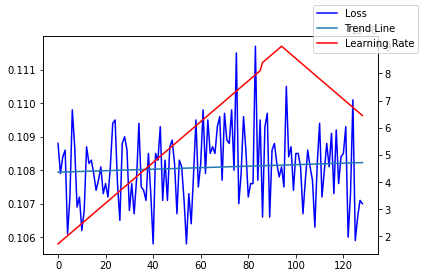

In [50]:
import matplotlib.pyplot as plt
import numpy as np

def smooth(data, window_width):
    ret = np.cumsum(np.insert(data, 0, 0)) 
    return (ret[window_width:] - ret[:-window_width]) / window_width
    
smooth_window = 1

start_idx = 2
end_idx = len(losses)
end_idx -= 20

smooth_loss = smooth(losses[start_idx:end_idx], smooth_window)
smooth_learning = smooth(learning_rates[start_idx:end_idx], smooth_window)

x_vals = np.arange(0, len(smooth_loss))
a, y = np.polyfit(x_vals, np.log(smooth_loss), 1)
print(smooth_loss)
print(smooth_learning)
x_vals = np.arange(0, len(smooth_loss))

def predicted_value(x, a, y):
    return np.exp(a*x) * np.exp(y)

y_vals = predicted_value(x_vals, a, y)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(smooth_loss, label="Loss", color="blue")
ax1.plot(x_vals, y_vals, label="Trend Line")
ax2.plot(smooth_learning, label="Learning Rate", color="red")

fig.legend()
fig.show()

print(f"y = {a}x + {y}")

future = predicted_value(0, a, y)
print("data start", future, np.exp(future))

future = predicted_value(len(smooth_loss), a, y)
print("data end", future, np.exp(future))

total_batches = 34200
print_rate = 500
one_epoch = total_batches/print_rate
future = predicted_value(len(smooth_loss) + one_epoch//2, a, y)
print("+0.5 epoch", future, np.exp(future))

future = predicted_value(len(smooth_loss) + one_epoch, a, y)
print("+1 epoch", future, np.exp(future))

future = predicted_value(len(smooth_loss) + one_epoch*2, a, y)
print("+2 epoch", future, np.exp(future))